# Analysis of stellar spectra


## Background Information on the dataset


You will be working with spectra of stars that have been aquired by the space telescope Gaia (https://www.esa.int/Science_Exploration/Space_Science/Gaia). 

For part of these stars, we have additional information from another observation mission GALAH (https://www.galah-survey.org/) that observed some of these stars as well. This will provide us with some labels for part of the dataset, but we don't (and can't, at the moment) know the "truth" for the stars that have not been observed by GALAH.


spectra are 1D data were each feature corresponds to a wavelength. Here the spectra span a wavelength range of 846–870 nm, with a step of 0.01 nm. 

### Data matrix:

spec_rvs_wise_galah.npy (spectra from Gaia for stars observed by both Gaia and GALAH)  = 21556 spectra of size 2401 each. We refer to it later as spectra_withgalah.
\
spec_NOgalah_rvswise.npy ((spectra from Gaia for stars observed only by Gaia) = 22295 spectra of size 2401 each. we refer to it later as spectraNOgal 

### Additional information dataframe:
gaiaGalah_info_rvswisegalah = information for the stars observed by both GALAH and Gaia (we refer to it later as gaiagal_info)
\
gaia_info_rvswiseNOgalah = information (partial) for the stars only observed by Gaia

### Indexing files:
(This shouldn't be necessary, as the spectra matrix and the dataframe should have the right order, but just in case)

ids_rvs_wise_galah = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "dr3_source_id" in gaiaGalah_info_rvswisegalah
\
ids_NOgalah_rvswise = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "source_id" in gaiaGalah_info_rvswisegalah




Example of a spectrum from the dataset: 

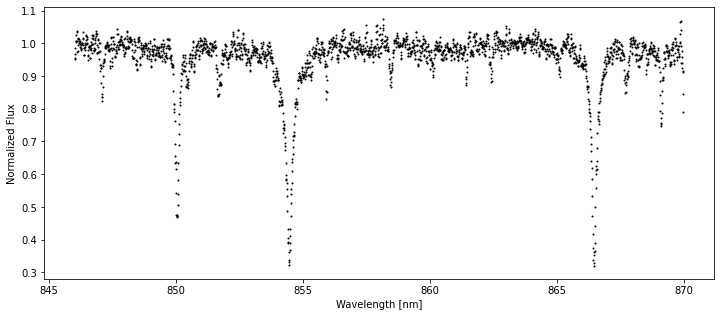


Spectras contain information about the composition of a star through absorbtion and emission lines:


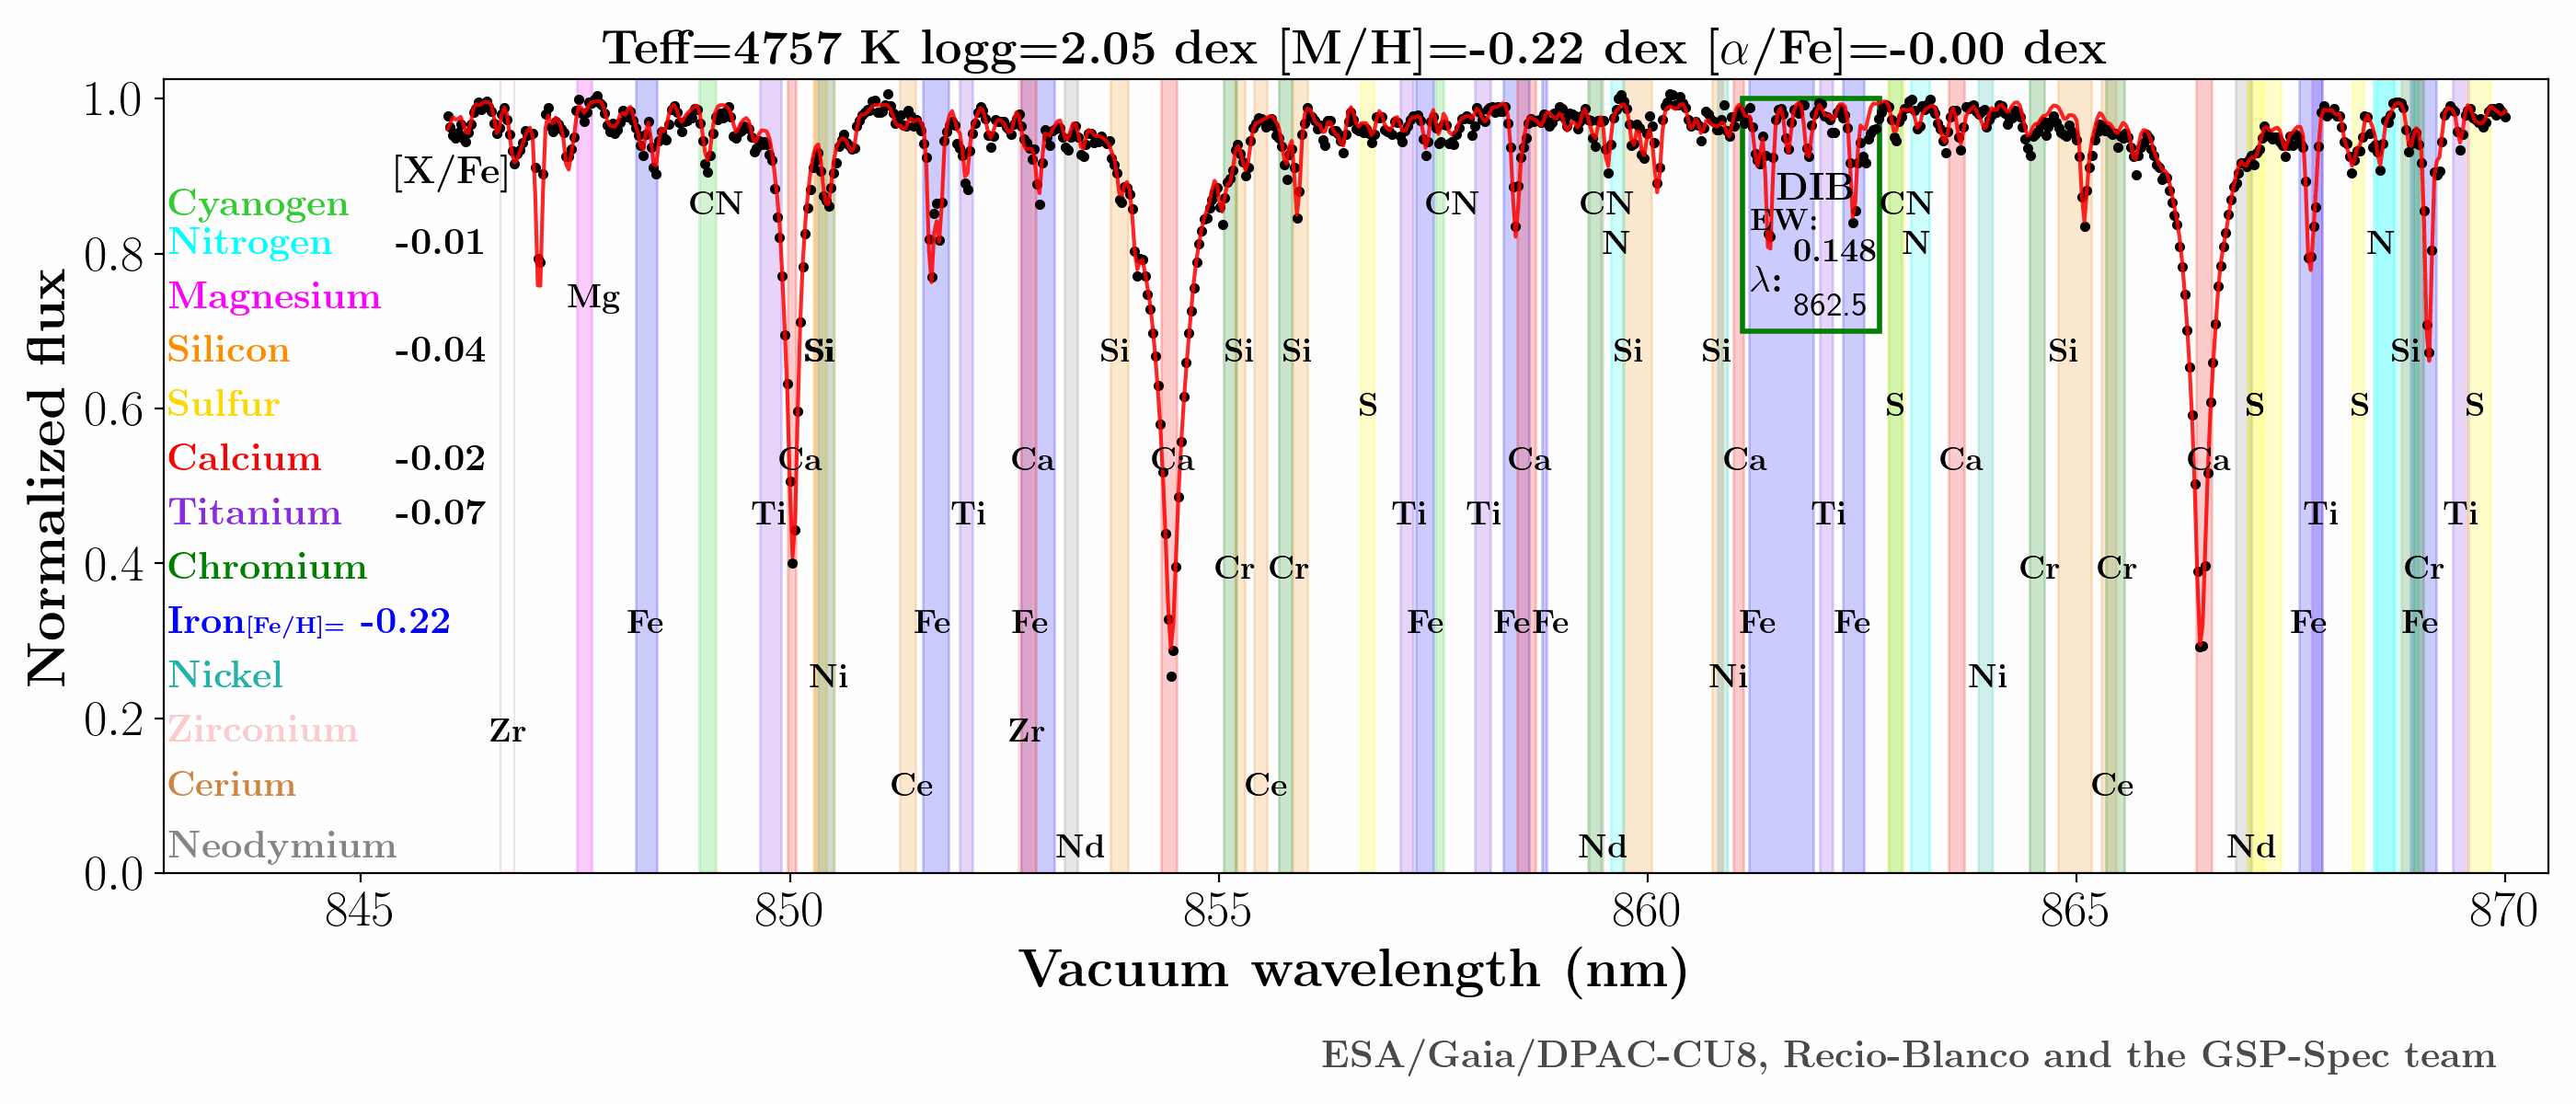

https://www.cosmos.esa.int/web/gaia/iow_20210709#

Different types of stars will have different looking spectras.
However, the spectra we get from Gaia are on a small range of wavelength, and not all interactions/emissions are known, neither necessarily the types of stars! 
On the other hand, GALAH observed those stars at larger wavelengths range (**verify**) and thus was able to produce some labels about metallicities and so on. 

One question that might be interesting to ask is: is there enough information from the Gaia spectra to predict those labels --we just don't know yet the "physically informed" way of doing it, but maybe it is possible! 

We're also interested in finding out if we see patterns or clusters in our dataset: they might indicate different type of stars (or, spoiler alert, observational issues...). 
Anomalies are also of interest, either finding extremely rare objects that we need to explain, or data impacted by observational artifact (most likely). 

## Task 1. Data Pre-Processing & Regression Pipeline

- Data pre-processing
- Filter for valid fe_h labels
- Split the data into training and testing sets
- Train and tune the models
  * RandomForestRegressor
  * LinearRegression
  * KNeighborsRegressor
- Hyperparameter Optimization
- Plot the true vs. predicted values
- Summarize the MSE results in a table

Ludwing Asturias [ludast@posteo.net](mailto:ludast@posteo.net) ![bayleef](https://archives.bulbagarden.net/media/upload/4/4e/Spr_2c_153.png)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score


In [ ]:
import cudf
import cuml
from cupy import asnumpy
from joblib import dump, load

In [ ]:
from cuml import svm
from cuml.preprocessing import SimpleImputer
from cuml.preprocessing import StandardScaler, MinMaxScaler
from cuml.datasets.classification import make_classification
from cuml.model_selection import train_test_split, GridSearchCV 
from cuml.linear_model import LinearRegression
from cuml.ensemble import RandomForestRegressor
from cuml.neighbors import KNeighborsRegressor
from cuml.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score


### Pre-processing

The spectra are in normalized flux, so they don't need to much pre-processing. However, **some spectra can contain NaN values; replace those values by the median of the given spectrum (i.e. of that row of the matrix) before carrying on!**  (your code will most likely crash if you don't anyway.)

Note the spectra file are .npy format you can load with numpy; the information tables can be loaded with pandas.

In [ ]:
# Load the .npy file using numpy
data_dir = './data/'

# Read data matrices
spectra_withgalah_np = np.load(data_dir + 'spec_rvs_wise_galah.npy')
spectra_withgalah = pd.DataFrame(spectra_withgalah_np)

spectraNOgal_np = np.load(data_dir + "spec_NOgalah_rvswise.npy")
spectraNOgal = pd.DataFrame(spectraNOgal_np)

# Read additional information
gaiagal_info = pd.read_csv(data_dir + "gaiaGalah_info_rvswisegalah.csv")
gaiaNOgal_info = pd.read_csv(data_dir + "gaia_info_rvswiseNOgalah.csv")

# Read IDs
ids_rvs_wise_galah_np = np.load(data_dir + 'ids_rvs_wise_galah.npy')
ids_rvs_wise_galah = pd.DataFrame(ids_rvs_wise_galah_np)

ids_NOgalah_rvswise_np = np.load(data_dir + 'ids_NOgalah_rvswise.npy')
ids_NOgalah_rvswise = pd.DataFrame(ids_NOgalah_rvswise_np)

In [5]:
print("Number of NaN (Gaia with galah)")
print("  Spectra =", spectra_withgalah.isna().sum().sum())
print("  info =", gaiagal_info.isna().sum().sum())
print("  IDs =", ids_rvs_wise_galah.isna().sum().sum())

Number of NaN (Gaia with galah)
  Spectra = 131180
  info = 992747
  IDs = 0


In [6]:
print("Number of NaN (Gaia NO galah)")
print("  Spectra =", spectraNOgal.isna().sum().sum())
print("  info =", gaiaNOgal_info.isna().sum().sum())
print("  IDs =", ids_NOgalah_rvswise.isna().sum().sum())

Number of NaN (Gaia NO galah)
  Spectra = 147436
  info = 731018
  IDs = 0


In [7]:
# Replace NaN values in each row with the median of that row
spectra_withgalah = spectra_withgalah.T.apply(lambda x: x.fillna(x.median()), axis=0).T
spectraNOgal = spectraNOgal.T.apply(lambda x: x.fillna(x.median()), axis=0).T

In [8]:
print("Number of NaN for each dataset")
print("Spectra with galah =", spectra_withgalah.isna().sum().sum())
print("Spectra NO galah =", spectraNOgal.isna().sum().sum())

Number of NaN for each dataset
Spectra with galah = 0
Spectra NO galah = 0


In [9]:
print("Shape of DF")
print("Spectra with galah", spectra_withgalah.shape)
print("Spectra NO galah", spectraNOgal.shape)

Shape of DF
Spectra with galah (21556, 2401)
Spectra NO galah (22295, 2401)


Try to plot a few spectra to see if you see differences between them!

In [10]:
# Standardize or Normalize each row
def scale_row(row):
    #scaler = StandardScaler() # Each row is now standardized: mean = 0, std = 1
    scaler = MinMaxScaler()    # Normalize each row to [0, 1]
    row_scaled = scaler.fit_transform(row.values.reshape(-1, 1)).flatten()
    return pd.Series(row_scaled, index=row.index)

spectra_withgalah_scaled = spectra_withgalah.apply(scale_row, axis=1)
spectraNOgal_scaled = spectraNOgal.apply(scale_row, axis=1)

In [11]:
import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'cm'
#matplotlib.rcParams['font.family'] = 'cmu serif'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

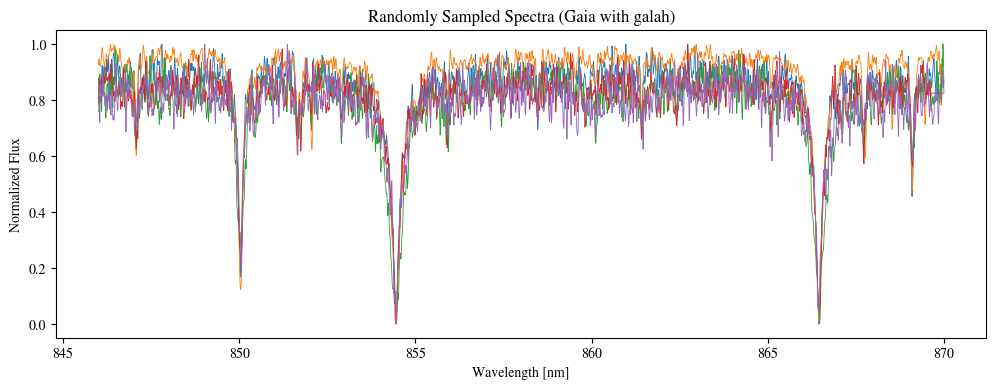

In [25]:
# Calculate the number of steps to include both ends
wl_step = 0.01
wl_min  = 846.0
wl_max  = 870.0
num_points = int((wl_max - wl_min) / wl_step) + 1  # +1 to include the endpoint

# Create the wavelength range
wl_range = np.linspace(wl_min, wl_max, num=num_points)

# Randomly sample 5 spectra (rows)
#sampled_spectra = spectra_withgalah.sample(n=5, random_state=24)
sampled_spectra = spectra_withgalah_scaled.sample(n=5, random_state=20250320)

# Plot each sampled spectrum as scatter points
plt.figure(figsize=(12, 4))
for idx, (label, row) in enumerate(sampled_spectra.iterrows()):
    plt.plot(wl_range, row, label=label, lw=0.6)
    #plt.scatter(wl_range, row, label=label, s=2)  # s controls marker size

plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalized Flux')
plt.title('Randomly Sampled Spectra (Gaia with galah)')
ax = plt.gca()
#plt.legend()
plt.show()


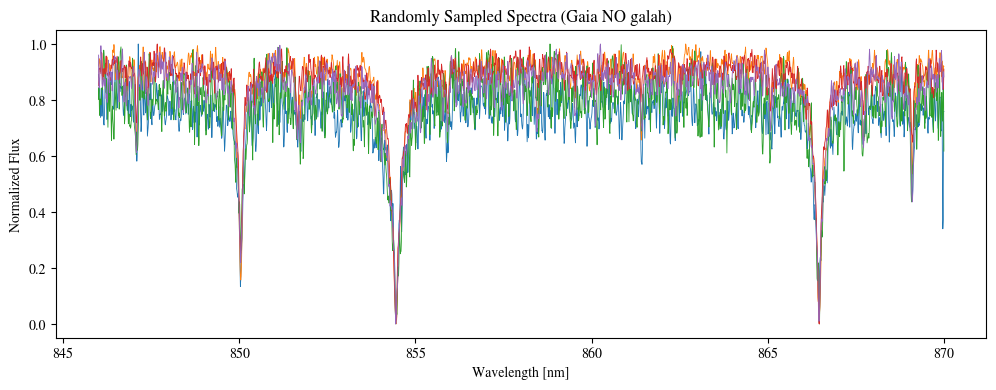

In [13]:
# Calculate the number of steps to include both ends
wl_step = 0.01
wl_min  = 846.0
wl_max  = 870.0
num_points = int((wl_max - wl_min) / wl_step) + 1  # +1 to include the endpoint

# Create the wavelength range
wl_range = np.linspace(wl_min, wl_max, num=num_points)

# Randomly sample 5 spectra (rows)
#sampled_spectra = spectra_withgalah.sample(n=5, random_state=24)
sampled_spectra = spectraNOgal_scaled.sample(n=5, random_state=20250320)

# Plot each sampled spectrum as scatter points
plt.figure(figsize=(12, 4))
for idx, (label, row) in enumerate(sampled_spectra.iterrows()):
    plt.plot(wl_range, row, label=label, lw=0.6)
    #plt.scatter(wl_range, row, label=label, s=2)  # s controls marker size

plt.xlabel('Wavelength [nm]')
plt.ylabel('Normalized Flux')
plt.title('Randomly Sampled Spectra (Gaia NO galah)')
ax = plt.gca()
#plt.legend()
plt.show()


### Metallicity Regression

One measurement that is interesting to astronomers is "metallicity". This can mean different thing, but in the context of this project, we will be considering the column "fe_h" in gaiagal_info. We will use this as our label for the regression task.\
For now, we can only use the spectra_withgalah / gaiagal_info since they are the only ones with this information. Since we need supervision for this task, ensure that you have proper labels for all your spectra --some might have a NaN fe_h!


Build a pipeline for this regression problem: construct a training and test set from the data, and train models to predict.Try (e.g. using sklearn) RandomForestRegressor (explore different hyper-parameters), LinearRegressor, and KNeighborsRegressor.\
You can plot the true labels (x-axis) vs the predicted labels (y-axis), for the train and test data.\
Summarize the error in prediction (using the Mean Square Error) for the models in a table.


In [12]:
metallicity_label = "fe_h"

# Number of NaN
invalid_rows_num = gaiagal_info[metallicity_label].isna().sum()
print("NaN values in", metallicity_label, "column =", invalid_rows_num)

# Find rows where Y is NOT NaN
valid_rows = gaiagal_info[metallicity_label].notna()
labels = gaiagal_info[metallicity_label]

# Filter both X and Y based on valid rows
X = spectra_withgalah_scaled[valid_rows].reset_index(drop=True)
y = labels.loc[valid_rows].reset_index(drop=True)

NaN values in fe_h column = 625


In [13]:
y.describe()

count    20931.000000
mean        -0.215673
std          0.348419
min         -4.781486
25%         -0.371472
50%         -0.168949
75%         -0.003002
max          1.000000
Name: fe_h, dtype: float64

In [ ]:
# We split the data randomnly into train and test sets using the cuml train_test_split and create CPU versions of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20250320)

In [ ]:
X_cpu = X_train.to_pandas()
y_cpu = y_train.to_numpy()

X_test_cpu = X_test.to_pandas()
y_test_cpu = y_test.to_numpy()

In [18]:
%%time
# creating a linear regression model 
model = LinearRegression()

# fitting the model 
model.fit(X_train,y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# model evaluation 
print("Multiple linear regression")
print('  MSE : ', mean_squared_error(y_test, y_test_pred)) 
print('  mean_absolute_error : ', mean_absolute_error(y_test, y_test_pred)) 
print("  R^2 Score:", r2_score(y_test, y_test_pred))
print("  Accuracy Score:", accuracy_score(y_test, y_test_pred))

Multiple linear regression
  MSE :  0.05853027239247936
  mean_absolute_error :  0.16219661693972315
  R^2 Score: 0.49346426770244756
  Accuracy Score: 0.9763497114181519
CPU times: user 1.02 s, sys: 36.4 ms, total: 1.06 s
Wall time: 1.12 s


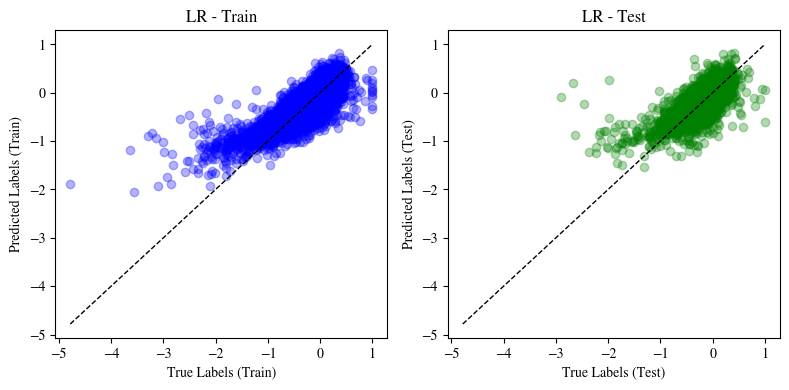

In [19]:
# Plot true vs predicted for both
plt.figure(figsize=(8, 4))

# Device to Host copy
y_host = y.to_numpy()
y_train_host = y_train.to_numpy()
y_test_host = y_test.to_numpy()
y_train_pred_host = y_train_pred.to_numpy()
y_test_pred_host = y_test_pred.to_numpy()

# Reference line (perfect prediction line)
min_val = min(y_host.min(), y_train_pred_host.min(), y_test_pred_host.min())
max_val = max(y_host.max(), y_train_pred_host.max(), y_test_pred_host.max())

# --- Train plot ---
plt.subplot(1, 2, 1)
plt.scatter(y_train_host, y_train_pred_host, color='blue', alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Train)")
plt.ylabel("Predicted Labels (Train)")
plt.title("LR - Train")

# --- Test plot ---
plt.subplot(1, 2, 2)
plt.scatter(y_test_host, y_test_pred_host, color='green', alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Test)")
plt.ylabel("Predicted Labels (Test)")
plt.title("LR - Test")

plt.tight_layout()
plt.show()


In [20]:
%%time
# Train the K-Nearest Neighbors Regressor
#knn = KNeighborsRegressor(n_neighbors=5, n_jobs=8)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

# model evaluation 
print("KNN regression")
print('  mean_squared_error : ', mean_squared_error(y_test, y_test_pred)) 
print('  mean_absolute_error : ', mean_absolute_error(y_test, y_test_pred)) 
print("  R^2 Score:", r2_score(y_test, y_test_pred))
print("  Accuracy Score:", accuracy_score(y_test, y_test_pred))

KNN regression
  mean_squared_error :  0.06392238526546583
  mean_absolute_error :  0.176310645782205
  R^2 Score: 0.4467995635911405
  Accuracy Score: 0.9799330830574036
CPU times: user 4.84 s, sys: 53 ms, total: 4.89 s
Wall time: 4.93 s


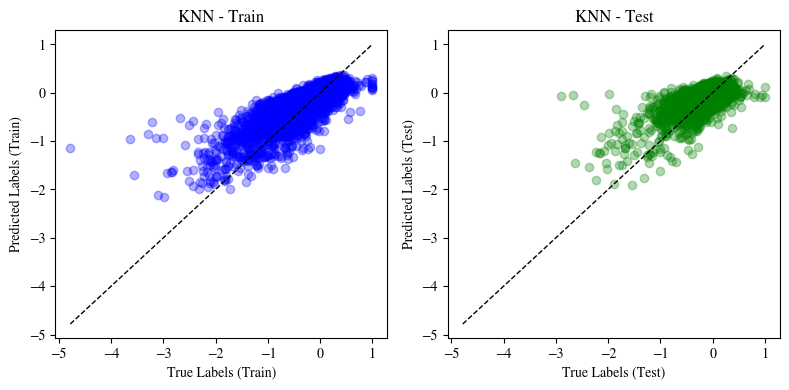

In [21]:
# Plot true vs predicted for both
plt.figure(figsize=(8, 4))

# Device to Host copy
y_host = y.to_numpy()
y_train_host = y_train.to_numpy()
y_test_host = y_test.to_numpy()
y_train_pred_host = y_train_pred.to_numpy()
y_test_pred_host = y_test_pred.to_numpy()

# Reference line (perfect prediction line)
min_val = min(y_host.min(), y_train_pred_host.min(), y_test_pred_host.min())
max_val = max(y_host.max(), y_train_pred_host.max(), y_test_pred_host.max())

# --- Train plot ---
plt.subplot(1, 2, 1)
plt.scatter(y_train_host, y_train_pred_host, color='blue', alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Train)")
plt.ylabel("Predicted Labels (Train)")
plt.title("KNN - Train")

# --- Test plot ---
plt.subplot(1, 2, 2)
plt.scatter(y_test_host, y_test_pred_host, color='green', alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Test)")
plt.ylabel("Predicted Labels (Test)")
plt.title("KNN - Test")

plt.tight_layout()
plt.show()


In [22]:
%%time

# random forest depth and size
# - n_estimators > 300 often give diminishing returns unless you have a huge dataset
# - If you see your model overfitting (train score >> test score), reduce max_depth
n_estimators = 1000
max_depth = 30

# Train the Random Forest model - CPU
#model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=8, random_state=20250320)

# Train the Random Forest model - GPU
model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_streams=1, random_state=20250320)

# Fit the model
trained_RF = model.fit(X_train, y_train)

# Predict for train and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# save
dump( trained_RF, 'RF.model')

# to reload the model uncomment the line below
#loaded_model = load('RF.model')

# model evaluation 
print("Random Forest regression")
print('  mean_squared_error : ', mean_squared_error(y_test, y_test_pred))
print('  mean_absolute_error : ', mean_absolute_error(y_test, y_test_pred)) 
print("  R^2 Score:", r2_score(y_test, y_test_pred))
print("  Train Accuracy Score:", accuracy_score(y_train, y_test_pred))
print("  Test Accuracy Score:", accuracy_score(y_test, y_test_pred))

Random Forest regression
  mean_squared_error :  0.051777515188350005
  mean_absolute_error :  0.15458786491067952
  R^2 Score: 0.5519043308630069
  Train Accuracy Score: 0.9610607028007507
  Test Accuracy Score: 0.979216456413269
CPU times: user 52.9 s, sys: 22.3 s, total: 1min 15s
Wall time: 1min 8s


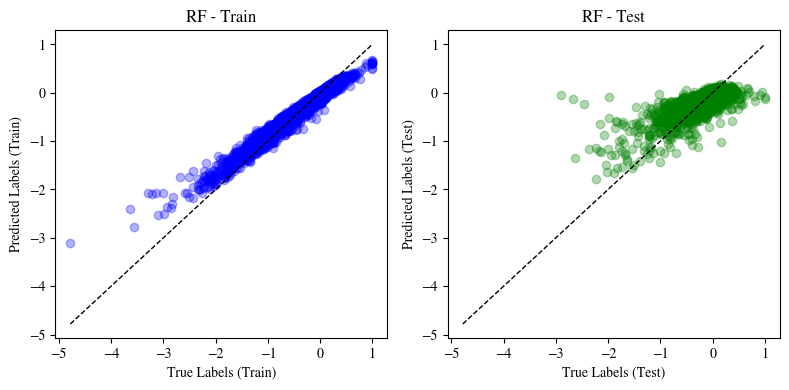

In [23]:
# Plot true vs predicted for both
plt.figure(figsize=(8, 4))

# Device to Host copy
y_host = y.to_numpy()
y_train_host = y_train.to_numpy()
y_test_host = y_test.to_numpy()
y_train_pred_host = y_train_pred.to_numpy()
y_test_pred_host = y_test_pred.to_numpy()

# Reference line (perfect prediction line)
min_val = min(y_host.min(), y_train_pred_host.min(), y_test_pred_host.min())
max_val = max(y_host.max(), y_train_pred_host.max(), y_test_pred_host.max())

# --- Train plot ---
plt.subplot(1, 2, 1)
plt.scatter(y_train_host, y_train_pred_host, color='blue', alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Train)")
plt.ylabel("Predicted Labels (Train)")
plt.title("RF - Train")

# --- Test plot ---
plt.subplot(1, 2, 2)
plt.scatter(y_test_host, y_test_pred_host, color='green', alpha=0.3)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1)
plt.xlabel("True Labels (Test)")
plt.ylabel("Predicted Labels (Test)")
plt.title("RF - Test")

plt.tight_layout()
plt.show()


In [18]:
# to reload the model uncomment the line below
loaded_model = load('RF.model')

# Predict for unseen set (Gaia only)
X_unseen = spectraNOgal_scaled
y_unseen = loaded_model.predict(X_unseen)

y_unseen.describe()

count    22295.000000
mean        -0.285467
std          0.312332
min         -1.958690
25%         -0.346622
50%         -0.217388
75%         -0.112620
max          0.272291
dtype: float64

### Hyperparameter optimization

In [ ]:
import warnings

warnings.filterwarnings("ignore")  # Reduce number of messages/warnings displayed

In [ ]:
import os
from urllib.request import urlretrieve

import cudf
import dask_ml.model_selection as dcv
import numpy as np
import pandas as pd
import xgboost as xgb
from cuml.ensemble import RandomForestRegressor
from cuml.metrics.accuracy import accuracy_score
from cuml.model_selection import train_test_split
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
from sklearn.metrics import make_scorer

In [ ]:
from cuml.experimental.hyperopt_utils import plotting_utils

In [ ]:
cluster = LocalCUDACluster()
client = Client(cluster)

client

In [ ]:
import time
from contextlib import contextmanager


# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

helper functions for performing HPO in 2 different modes:
1. gpu-grid: Perform GPU based GridSearchCV
1. gpu-random: Perform GPU based RandomizedSearchCV

In [ ]:
# Define some default values to make use of across the notebook for a fair comparison
N_FOLDS = 5
N_ITER = 25
label = "fe_h"

In [ ]:
def accuracy_score_wrapper(y, y_hat):
    """
    A wrapper function to convert labels to float32,
    and pass it to accuracy_score.

    Params:
    - y: The y labels that need to be converted
    - y_hat: The predictions made by the model
    """
    y = y.astype("float32")  # cuML RandomForest needs the y labels to be float32
    return accuracy_score(y, y_hat, convert_dtype=True)


accuracy_wrapper_scorer = make_scorer(accuracy_score_wrapper)
cuml_accuracy_scorer = make_scorer(accuracy_score, convert_dtype=True)

In [ ]:
def do_HPO(model, gridsearch_params, scorer, X, y, mode="gpu-Grid", n_iter=10):
    """
    Perform HPO based on the mode specified

    mode: default gpu-Grid. The possible options are:
    1. gpu-grid: Perform GPU based GridSearchCV
    2. gpu-random: Perform GPU based RandomizedSearchCV

    n_iter: specified with Random option for number of parameter settings sampled

    Returns the best estimator and the results of the search
    """
    if mode == "gpu-grid":
        print("gpu-grid selected")
        clf = dcv.GridSearchCV(model, gridsearch_params, cv=N_FOLDS, scoring=scorer)
    elif mode == "gpu-random":
        print("gpu-random selected")
        clf = dcv.RandomizedSearchCV(
            model, gridsearch_params, cv=N_FOLDS, scoring=scorer, n_iter=n_iter
        )

    else:
        print("Unknown Option, please choose one of [gpu-grid, gpu-random]")
        return None, None
    res = clf.fit(X, y)
    print(f"Best clf and score {res.best_estimator_} {res.best_score_}\n---\n")
    return res.best_estimator_, res

In [ ]:
def print_acc(model, X_train, y_train, X_test, y_test, mode_str="Default"):
    """
    Trains a model on the train data provided, and prints the accuracy of the trained model.
    mode_str: User specifies what model it is to print the value
    """
    y_pred = model.fit(X_train, y_train).predict(X_test)
    score = accuracy_score(y_pred, y_test.astype("float32"), convert_dtype=True)
    print(f"{mode_str} model accuracy: {score}")

Let’s use RandomForest Regression to perform a hyper-parameter search

In [ ]:
## Random Forest
model_rf_ = RandomForestRegressor()

params_rf = {
    "max_depth": np.arange(start=10, stop=40, step=10),  # Default = 6
    #"max_features": [0.1, 0.50, 0.75, "auto"],  # default = 0.3
    "n_estimators": [300, 500, 1000],
}


for col in X_train.columns:
    X_train[col] = X_train[col].astype("float32")
y_train = y_train.astype("int32")

In [ ]:
print(
    "Default acc: ",
    accuracy_score(model_rf_.fit(X_train, y_train).predict(X_test), y_test),
)

In [ ]:
mode = "gpu-random"
model_rf = RandomForestRegressor()


with timed("RF-" + mode):
    res, results = do_HPO(
        model_rf,
        params_rf,
        cuml_accuracy_scorer,
        X_train,
        y_cpu,
        mode=mode,
        n_iter=N_ITER,
    )
num_params = len(results.cv_results_["mean_test_score"])
print(f"Searched over {num_params} parameters")

In [35]:
print("Improved acc: ", accuracy_score(res.predict(X_test), y_test))

Improved acc:  0.979216456413269


In [ ]:
df_gridsearch = pd.DataFrame(results.cv_results_)

plotting_utils.plot_heatmap(df_gridsearch, "param_max_depth", "param_n_estimators")

![Grid_Search](./hmap_gridsearch.png)

## Visualization and dimensionality reduction exploration

Apply PCA on the spectra_withgalah, and \
  a) plot the explained variance ratio as a function of the number of components; \
  b) plot scatter plots of the lower-dimensional PCA-transformed space using few components (e.g. using the 0th/1st components, 0th/2d); what do you observe? \
  c) plot the first 3 PCA components (i.e. in "spectra" space) 
  
 

Apply PCA on the other spectra dataset (spec_NOgalah_rvswise) and compare the results (specifically b) and c)). 


(Optional): Try another algorithm for visualization/dimensionality reduction like t-SNE or UMAP.

## Clustering

Using the lower dimensional space from PCA (e.g. with even only 2 or 3 components) on the spectraNOgal dataset, run a clustering algorithm to separate your data. \
For each of the cluster you find, plot the average spectra of this cluster. 

## Anomaly Detection 


Run IsolationForest on the spectraNOGal (in high-dimension, not reduced). Find the 5 most anomalous spectra using the score_samples function, and report them back on the PCA projection plot. Plot as well the 5 spectra. What do you observe? 

